In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
audio = pd.read_csv("full_dataset.csv")
audio.drop(['Unnamed: 0', 'TrackID', 'artist_id', 'lyrics'], axis = 1, inplace=True)
audio.head(5)

,track,popularity,artist,duration,explicit,speechiness,energy,loudness,valence,instrumentalness,danceability,tempo,time_signature,key,mode,acousticness,liveness,release_date
0,"""Eye"" No, Alphabet St., Glam Slam, Anna Stesia...",33,Prince,2703226,True,0.0855,0.652,-13.122,0.467,0.00438,0.550,124.378,4.0,8.0,1.0,0.242000,0.1010,5/10/88
1,"""Heroes"" - 2017 Remastered Version",42,David Bowie,371413,False,0.0297,0.758,-6.491,0.435,0.48400,0.490,112.114,4.0,7.0,1.0,0.000671,0.0920,9/29/17
2,"""Heroes"" - Live, 2017 Remastered Version",34,David Bowie,380426,False,0.0364,0.786,-7.292,0.828,0.01030,0.508,113.865,4.0,7.0,1.0,0.102000,0.9850,9/29/17
3,"""Heroes"" / ""H?ros""",37,David Bowie,365293,False,0.0294,0.764,-5.743,0.435,0.26700,0.494,112.232,4.0,7.0,1.0,0.004360,0.2650,9/29/17
4,"""Heroes"" / ""Helden""",40,David Bowie,367306,False,0.0317,0.662,-9.158,0.447,0.00996,0.462,112.842,4.0,7.0,1.0,0.004690,0.0775,9/29/17


In [7]:
# create extra column for decades from release date
audio['release_date'] = pd.to_datetime(audio['release_date'], infer_datetime_format=True)

audio['year'] = audio['release_date'].dt.year
audio['month'] = audio['release_date'].dt.month
audio.drop(['release_date'], axis=1, inplace=True)


In [8]:
audio.duration = audio.duration/1000 # from ms to seconds
audio = audio[audio['year'] <= 2018] # remove those tracks from future
# create decades column
audio['decade'] = np.where(audio.year <= 1969, "60s",
                           np.where(audio.year <= 1979, "70s", 
                                   np.where(audio.year <= 1989, "80s",
                                           np.where(audio.year <= 1999, "90s",
                                                   np.where(audio.year <= 2009, "00s", "10s")))))
# set data type correctly
for i in ['track', 'artist', 'key', 'mode', 'year', 'month', 'decade', 'time_signature']:
    audio[i] = audio[i].astype(np.object)
    
audio['explicit'] = audio['explicit'].astype(np.bool_)

audio.head()

,track,popularity,artist,duration,explicit,speechiness,energy,loudness,valence,instrumentalness,danceability,tempo,time_signature,key,mode,acousticness,liveness,year,month,decade
0,"""Eye"" No, Alphabet St., Glam Slam, Anna Stesia...",33,Prince,2703.226,True,0.0855,0.652,-13.122,0.467,0.00438,0.550,124.378,4,8,1,0.242000,0.1010,1988,5,80s
1,"""Heroes"" - 2017 Remastered Version",42,David Bowie,371.413,False,0.0297,0.758,-6.491,0.435,0.48400,0.490,112.114,4,7,1,0.000671,0.0920,2017,9,10s
2,"""Heroes"" - Live, 2017 Remastered Version",34,David Bowie,380.426,False,0.0364,0.786,-7.292,0.828,0.01030,0.508,113.865,4,7,1,0.102000,0.9850,2017,9,10s
3,"""Heroes"" / ""H?ros""",37,David Bowie,365.293,False,0.0294,0.764,-5.743,0.435,0.26700,0.494,112.232,4,7,1,0.004360,0.2650,2017,9,10s
4,"""Heroes"" / ""Helden""",40,David Bowie,367.306,False,0.0317,0.662,-9.158,0.447,0.00996,0.462,112.842,4,7,1,0.004690,0.0775,2017,9,10s


In [213]:
# descriptive analysis

# average attributes by decades
aver_audio = audio.drop(['explicit', 'month', 'key', 'mode', 'time_signature', 'year'], axis=1).groupby("decade", as_index=True).mean()
aver_audio = aver_audio.reindex_axis(['60s', '70s', '80s', '90s', '00s', '10s'], axis=0)

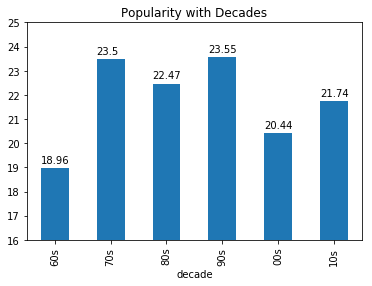

In [214]:
popularity_plt = aver_audio.popularity.plot.bar(title='Popularity with Decades', ylim=(16, 25))

for idx, label in enumerate(list(aver_audio.index)): 
        value = np.round(aver_audio.iloc[idx]['popularity'],decimals=2)
        popularity_plt.annotate(value,
                    (idx-0.25, value+0.2))

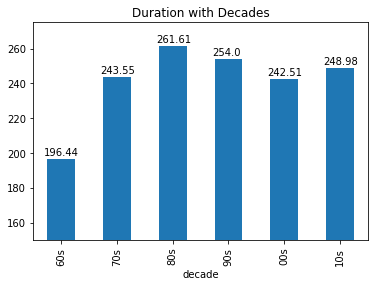

In [216]:
duration_plt = aver_audio.duration.plot.bar(title='Duration with Decades', ylim=(150, 275))

for idx, label in enumerate(list(aver_audio.index)): 
        value = np.round(aver_audio.iloc[idx]['duration'],decimals=2)
        duration_plt.annotate(value,
                    (idx-0.3, value+2))

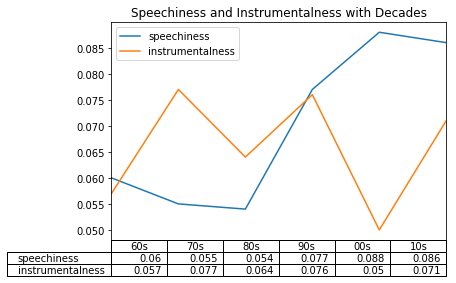

In [194]:
si_plt = np.round(aver_audio[["speechiness", "instrumentalness"]], decimals=3).plot(title="Speechiness and Instrumentalness with Decades", table=True, xticks=None)
si_plt.get_xaxis().set_visible(False)

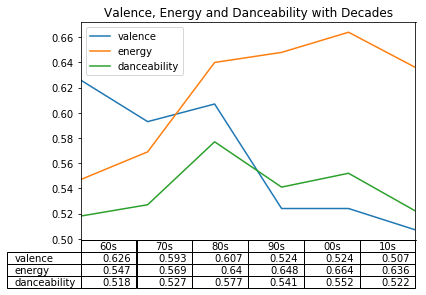

In [197]:
ved_plt = np.round(aver_audio[["valence", "energy", "danceability"]], decimals=3).plot(title="Valence, Energy and Danceability with Decades", table=True)
ved_plt.get_xaxis().set_visible(False)

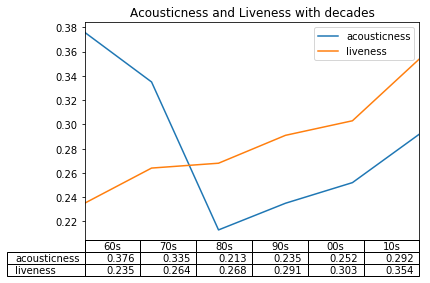

In [198]:
al_plt = np.round(aver_audio[['acousticness', 'liveness']], decimals=3).plot(title="Acousticness and Liveness with decades", table=True)
al_plt.get_xaxis().set_visible(False)

In [257]:
# best and worst artist in different decades
aver_artist = audio.popularity.groupby([audio['decade'], audio['artist']]).mean()
for i in ["60s", '70s', '80s', '90s', '00s', '10s']:
    artists = aver_artist[i]
    print("%s 5 most popular artists:"%i)
    print(", ".join(artists.nlargest(5).index.values))
    print("%s 5 least popular artists:"%i)
    print(", ".join(artists.nsmallest(5).index.values))
    print("="*10)

60s 5 most popular artists:
Simon & Garfunkel, The Doors, Buffalo Springfield, Creedence Clearwater Revival, The Young Rascals
60s 5 least popular artists:
Seals and Crofts, The Hollies, Sonny & Cher, The Rascals, Frankie Valli & The Four Seasons
70s 5 most popular artists:
Simon & Garfunkel, Michael Jackson, Pink Floyd, Eagles, Jackson Browne
70s 5 least popular artists:
The Surfaris, The Rascals, Freda Payne, Lesley Gore, The Turtles
80s 5 most popular artists:
Tracy Chapman, Eagles, Simon & Garfunkel, Prince, Dire Straits
80s 5 least popular artists:
Dusty Springfield, Foghat, Deniece Williams, Extreme, The Guess Who
90s 5 most popular artists:
Destiny's Child, Radiohead, Spice Girls, Green Day, Britney Spears
90s 5 least popular artists:
Debby Boone, Starship, Mary Wells, Paul Davis, The Chi-Lites
00s 5 most popular artists:
Red Hot Chili Peppers, JAY Z, Radiohead, Britney Spears, Avril Lavigne
00s 5 least popular artists:
Christopher Cross, Gary Wright, Tears For Fears, Hot Chocol

In [274]:
# best and worst tracks in different decades
for i in ["60s", '70s', '80s', '90s', '00s', '10s']:
    print("%s 5 most popular tracks:"%i)
    print(", ".join(list(audio[audio['decade']==i][['popularity', 'track']].sort_values('popularity', ascending=False)[:5]['track'])))
    print("%s 5 least popular tracks:"%i)
    print(", ".join(list(audio[audio['decade']==i][['popularity', 'track']].sort_values('popularity')[:5]['track'])))
    print("="*10)

60s 5 most popular tracks:
Fortunate Son, Mrs. Robinson, Bad Moon Rising, The Sound of Silence, California Dreamin'
60s 5 least popular tracks:
Penthouse Pauper, Crazy Otto - Live at The Fillmore, Sing A Simple Song - Live at The Woodstock Music & Art Fair, August 16, 1969, Bootleg - Alternate Take, Born On The Bayou - Live In London
70s 5 most popular tracks:
Dreams - 2004 Remastered Edition, The Chain - 2004 Remastered Edition, Another Brick in the Wall, Pt. 2, Go Your Own Way - 2004 Remastered Edition, Landslide
70s 5 least popular tracks:
Frightened Lady - 1999 Remastered Version, Mad Professor Blyth, Somethin' Else, Too Young To Be Married - 1999 Remastered Version, You're Gonna Get What's Coming
80s 5 most popular tracks:
Fast Car, Wake Me up Before You Go-Go, Every Breath You Take - Remastered 2003, Kiss, Maneater - Remastered
80s 5 least popular tracks:
I've Been Born Again (Live: The Paradise, Boston MA) (3 Oct 82), Don't Give Up (Live: The Paradise, Boston MA) (3 Oct 82), Roc

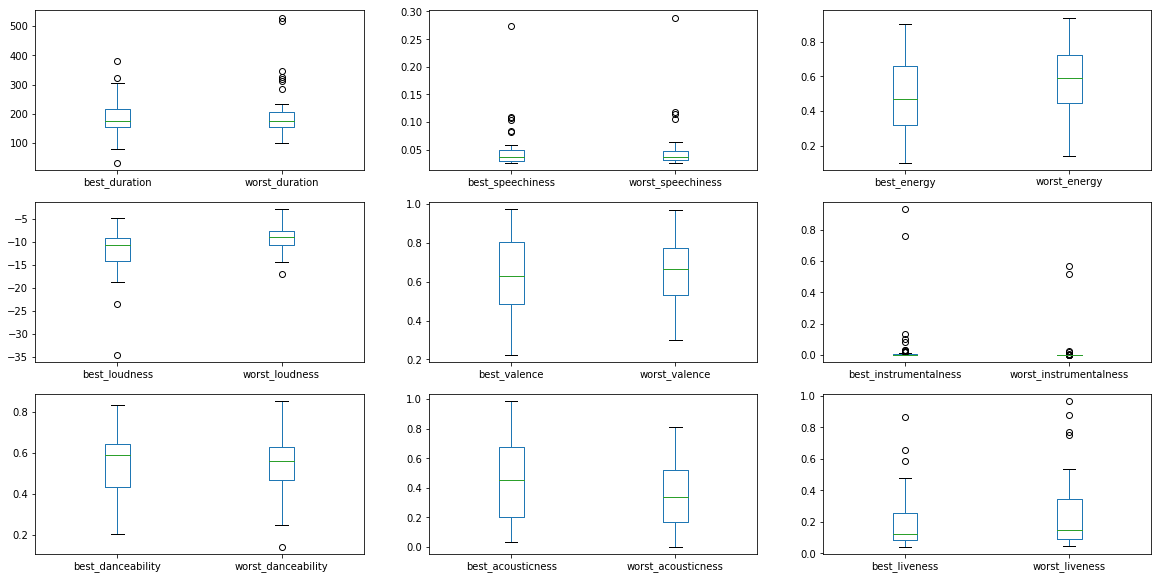

In [307]:
# comparison between the top 50 most and least popular tracks in each decades?

# 60s
bests = audio[audio['decade']=='60s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='60s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

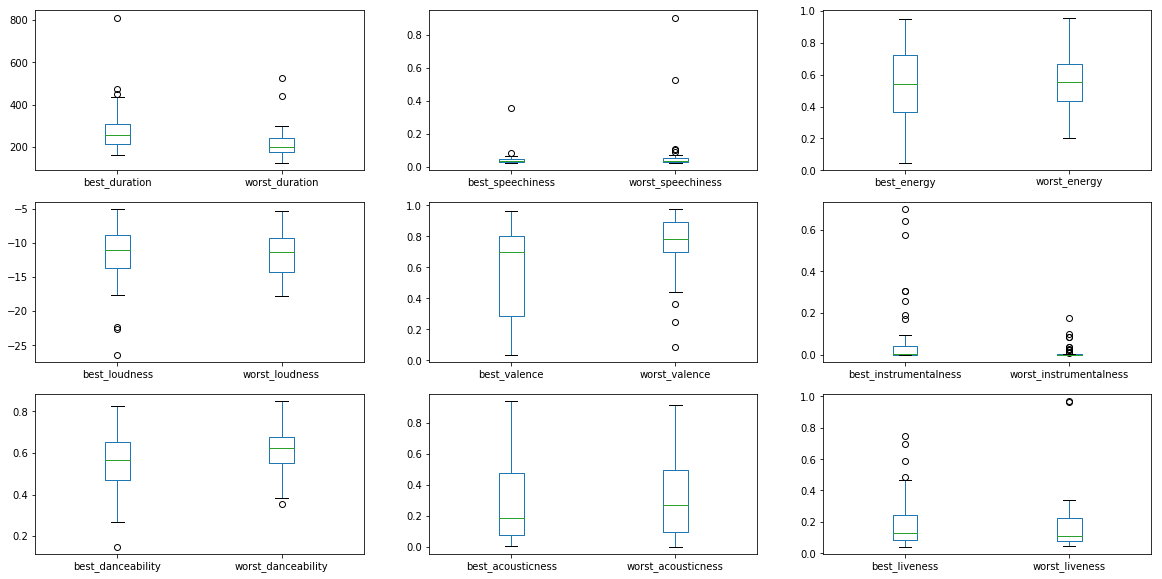

In [308]:
# 70s
bests = audio[audio['decade']=='70s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='70s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

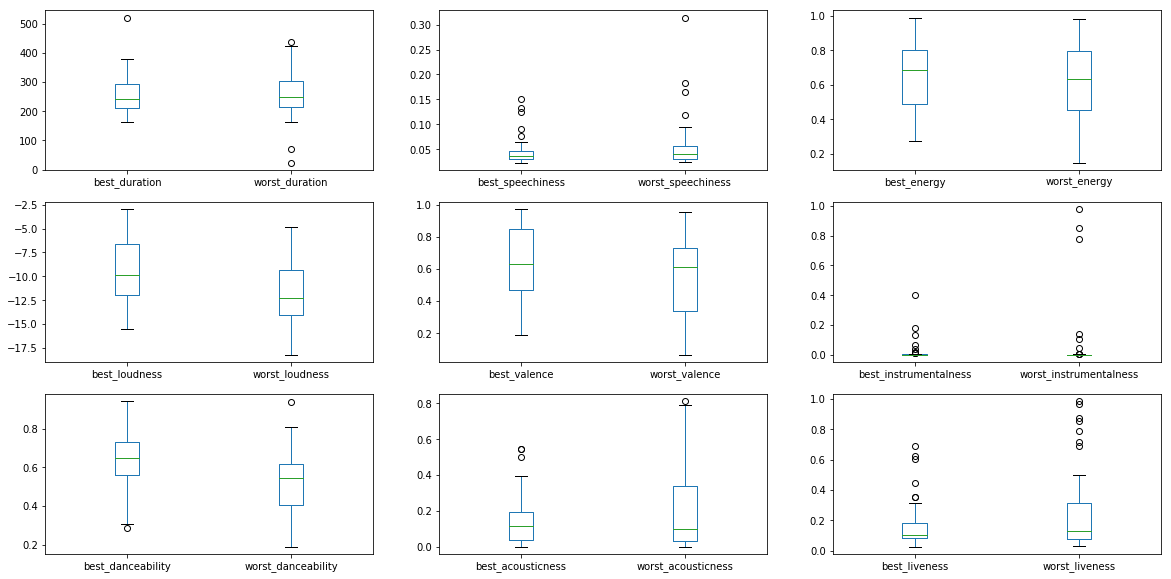

In [309]:
# 80s
bests = audio[audio['decade']=='80s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='80s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

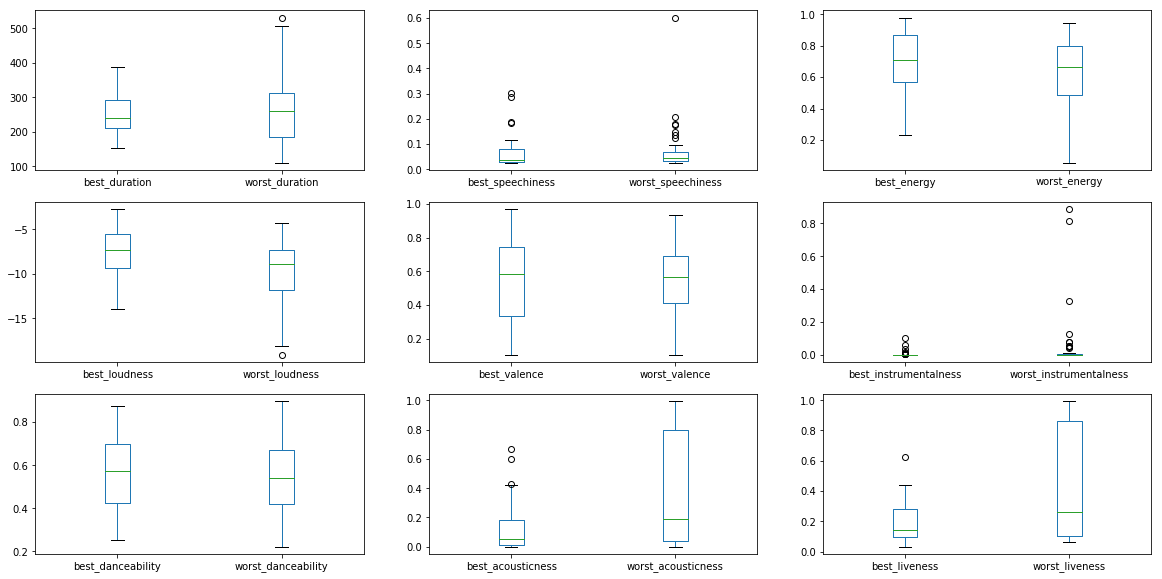

In [310]:
# 90s
bests = audio[audio['decade']=='90s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='90s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

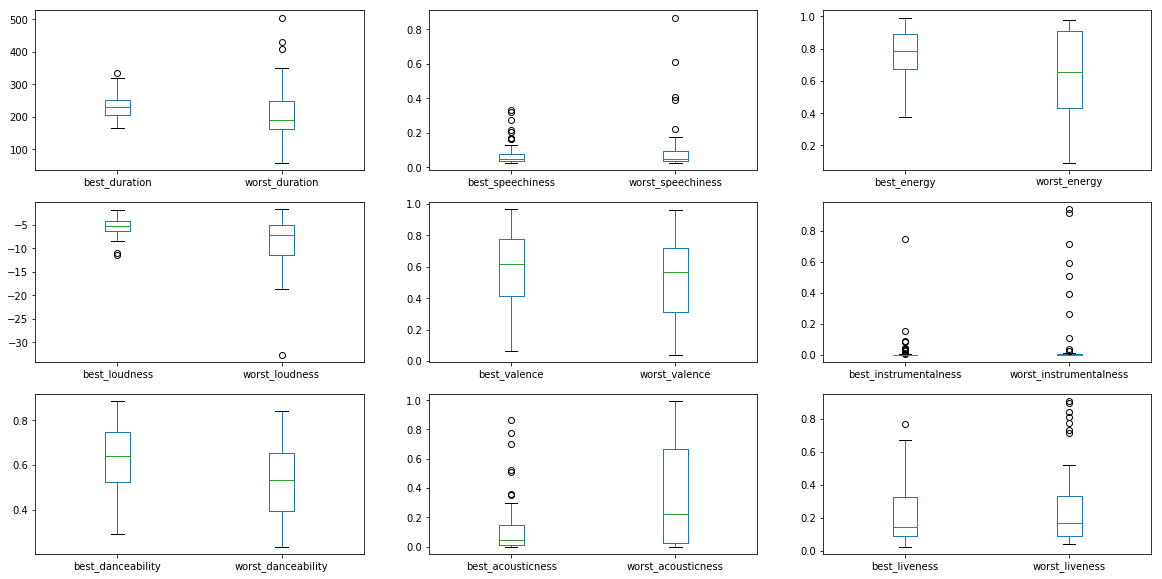

In [311]:
# 00s
bests = audio[audio['decade']=='00s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='00s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

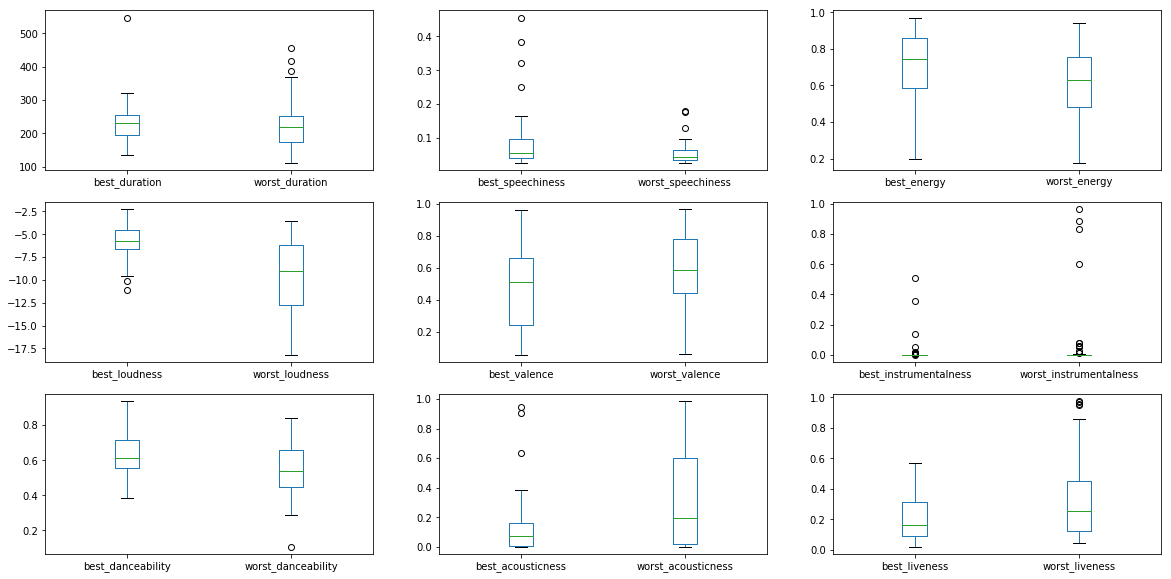

In [312]:
# 10s
bests = audio[audio['decade']=='10s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='10s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

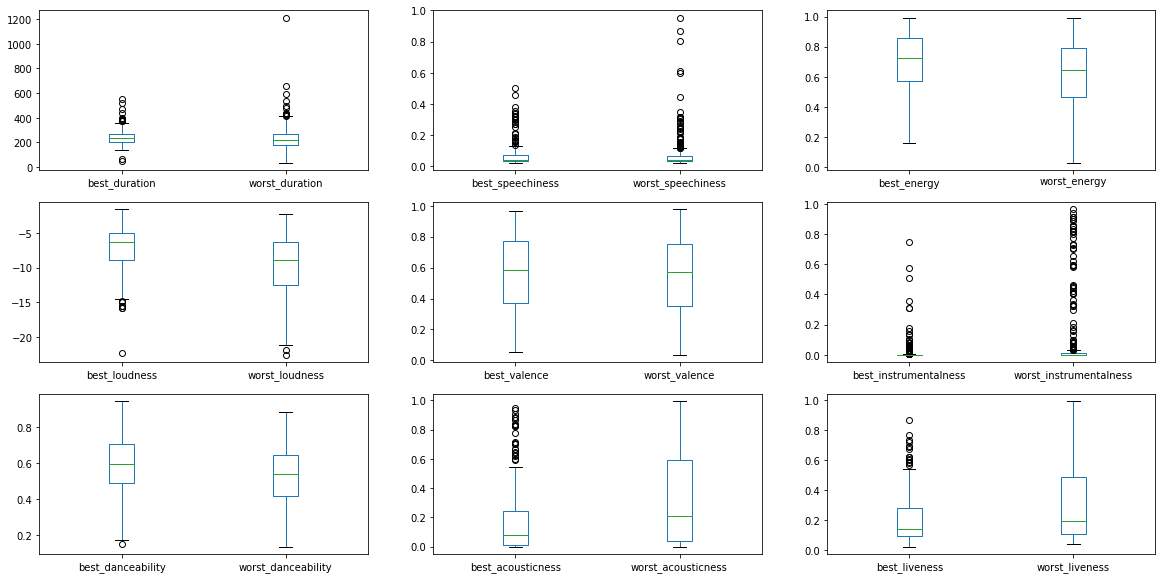

In [313]:
# overall, 300 best vs 300 worst
bests = audio.sort_values('popularity', ascending=False)[:300]
worsts = audio.sort_values('popularity', ascending=True)[:300]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

In [11]:
# predictive modelling - use attributes to predict popularity score
audio.corr()

,popularity,duration,explicit,speechiness,energy,loudness,valence,instrumentalness,danceability,tempo,acousticness,liveness
popularity,1.000000,0.062779,0.111307,-0.024513,0.051477,0.087983,-0.047652,0.033041,0.046812,0.000005,-0.096379,-0.065278
duration,0.062779,1.000000,-0.035157,-0.138594,0.111879,0.044762,-0.170692,0.083942,-0.123870,0.001212,-0.163905,0.193673
explicit,0.111307,-0.035157,1.000000,0.261707,0.079442,0.118866,0.003224,-0.044441,0.143200,-0.027190,-0.103379,-0.035432
speechiness,-0.024513,-0.138594,0.261707,1.000000,0.018462,-0.102393,0.042464,-0.060904,0.116085,-0.006800,0.053905,0.107164
energy,0.051477,0.111879,0.079442,0.018462,1.000000,0.739938,0.266350,-0.018458,0.007955,0.187225,-0.687254,0.222666
loudness,0.087983,0.044762,0.118866,-0.102393,0.739938,1.000000,0.119095,-0.156030,0.054230,0.112899,-0.518349,0.035833
valence,-0.047652,-0.170692,0.003224,0.042464,0.266350,0.119095,1.000000,-0.079004,0.509810,0.091083,-0.172567,-0.147459
instrumentalness,0.033041,0.083942,-0.044441,-0.060904,-0.018458,-0.156030,-0.079004,1.000000,-0.097225,0.005524,-0.002858,-0.003199
danceability,0.046812,-0.123870,0.143200,0.116085,0.007955,0.054230,0.509810,-0.097225,1.000000,-0.173622,-0.100953,-0.318585
tempo,0.000005,0.001212,-0.027190,-0.006800,0.187225,0.112899,0.091083,0.005524,-0.173622,1.000000,-0.138752,0.028112


In [55]:
train_X = audio.drop(['popularity', 'track', 'year', 'month'], axis=1)
train_X['duration'] = ((audio.duration - audio.duration.min())/(audio.duration.max()- audio.duration.min()))
train_X['loudness'] = ((audio.loudness - audio.loudness.min())/(audio.loudness.max()- audio.loudness.min()))
train_X['tempo'] = ((audio.tempo - audio.tempo.min())/(audio.tempo.max()- audio.tempo.min()))
# train_X = pd.get_dummies(train_X)
train_y = np.log(audio['popularity'])
train_y = audio['popularity']
xgb = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=0.7, max_depth=7, silent = False)

In [56]:
pipe = make_pipeline(xgb)
cross_val_score(pipe, train_X, train_y, cv=10, scoring='neg_mean_squared_error').mean()

-103.4543887142238

1.598113015039863